In [5]:
from IPython.core.display import HTML as Center

Center(
""" 
<style>
    .output_png {
        display: table-cell;
        text-align: center;
        vertical-align: middle;       
    }
</style> 
""")

$
\newcommand{\nc}{\newcommand} 
\nc{\t}{\text}
\nc{\tb}{\textbf}
\nc{\ti}{\textit}
\nc{\md}{\, \mid \,}
\nc{\mX}{\mathcal{D}}
\nc{\E}{\mathbb{E}}
\nc{\lrg}{\large}
\nc{\where}{\ \text{where}\ }
\require{color}
\nc{\qw}{{\color{blue}{q(w)}}}
\nc{\sumJ}{\sum_{j=1}^{J}}
\nc{\D}{\mathcal{D}}
\nc{\ltxt}[1]{\large\text{#1}}
\nc{\ws}{\ w^*  }
\nc{\wj}{\ w^{(j)} }
\nc{\wo}{\ w^{(j-1)} }
\require{amsmath}
$

# $$\textbf{Python Programming for Machine Learning} $$ 

### $$\t{Fitting a distribution}$$ 
### $$\t{Probabilistic programming language}$$

#### $$\text{Winter Semester 2022/23}$$
#### $$\text{Sergej Dogadov and Panagiotis Tomer Karagianis}$$

<center>
<img src='./images/pyt.png' width=350>

## $$\tb{Credit approval dataset}$$
<hr>
<br>

<center>
<img src='./images/yes_no.jpg' width=450>

In [6]:
import numpy as np
import pandas as pd

In [7]:
data = pd.read_csv('./data/crx.data', delimiter=',', header=None)
print(f"Data shape: {data.shape}")
data.head(3)

Data shape: (690, 16)


0      1     2  3  4  5  6     7  8  9   10 11 12     13   14 15
0  b  30.83  0.00  u  g  w  v  1.25  t  t   1  f  g  00202    0  +
1  a  58.67  4.46  u  g  q  h  3.04  t  t   6  f  g  00043  560  +
2  a  24.50  0.50  u  g  q  h  1.50  t  f   0  f  g  00280  824  +

## $$\tb{Clean up the data}$$
<hr>
<br>

* $\t{Find missing values}$

In [8]:
data[0].unique(), data.shape

(array(['b', 'a', '?'], dtype=object), (690, 16))

* $\t{Remove missing values}$

In [9]:
data = data.replace(to_replace='?', value=np.nan).dropna()
data.shape

(653, 16)

## $$\tb{Checking the class balance}$$
<hr>
<br>

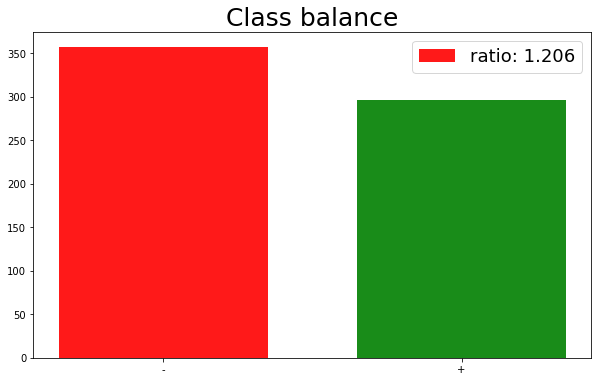

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

y = data[15].value_counts()

plt.figure(figsize=(10, 6))
plt.bar(['-', '+'], y, color = ['r','g'], width=0.7, alpha=.9, label = f'ratio: {y[0]/y[1]:.3f}')

plt.title("Class balance", fontsize=25)
plt.legend(loc='best', fontsize=18);

## $$\tb{Analyzing a feature}$$
<hr>
<br>

In [11]:
# Cast a column values to float and get an ndarray
feature_idx = 1

feature_values = data[feature_idx].astype(float).to_numpy()
feature_values[:10]

array([30.83, 58.67, 24.5 , 27.83, 20.17, 32.08, 33.17, 22.92, 54.42,
       42.5 ])

In [12]:
def plot_hist(values, likelihood=None):
    
    ax = plt.figure(figsize=(16, 8)).gca()
    
    ax.hist(values, bins=30, rwidth=0.8, density=True)
    ax.set_title('Histogram plot', fontsize=20)
    
    if likelihood is not None:
        
        assert callable(likelihood)
        
        values = np.sort(values)
        min_val, max_val = values[0], values[-1]
        
        alpha, loc, beta = likelihood.fit(values)
        
        log_pdfs = likelihood.logpdf(values, a=alpha, loc=loc, scale=beta)
        ax.plot(values, np.exp(log_pdfs), 'r--', linewidth=3)
        
    return ax  

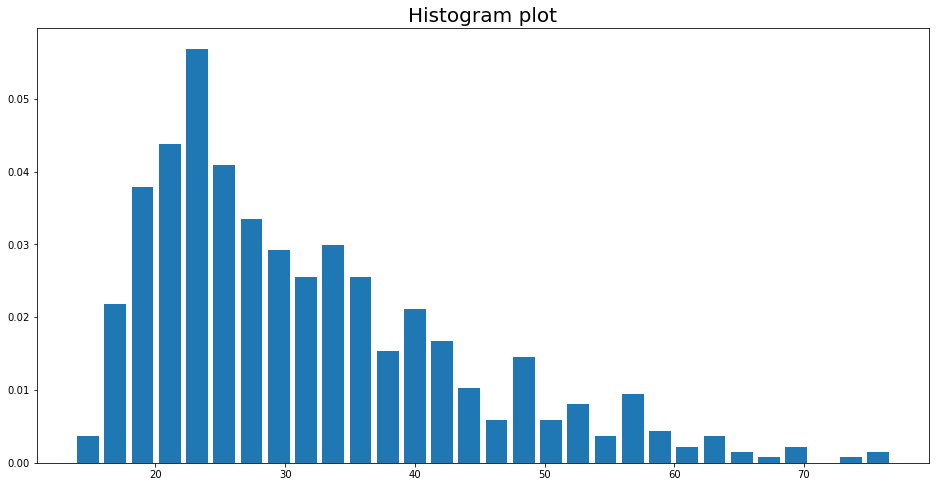

In [13]:
plot_hist(feature_values);

* $\tb{Note:} \t{ All values are strictly positive and bigger then a value (some offset).}$

## $$\tb{Gamma distribution}$$
<hr>
<br>

* $\t{Probability density function (PDF)}$

$$\Large{
p(x) = \frac{\beta^\alpha}{\Gamma(\alpha)} x^{\alpha-1}e^{-\beta x}, \t{ where } \alpha > 0 \t{ and } \beta > 0
}$$

* $\t{Log probability density function}$

$$\Large{
\ln p(x) = \alpha\ln(\beta) - \ln{\Gamma(\alpha)} + (\alpha-1)\ln(x) -\beta x
}$$

In [14]:
from scipy.special import loggamma

def log_gamma(x, alpha, beta):
    assert alpha > 0, "alpha value is strict positive"
    assert beta > 0, "beta value is strict positive"
    
    return alpha * np.log(beta) - loggamma(alpha) + (alpha - 1) * np.log(x) - beta * x


## $$\tb{Gamma distribution (cont'd)}$$
<hr>
<br>

In [15]:
alphas = [1, 2, 5]
betas = [2, 1, 0.5]
x_range = np.linspace(0.01, 12, 100)

In [16]:
def plot_gamma_pdfs(x_range, alphas, betas, log_pdf):
    
    n_rows, n_cols = len(alphas), len(betas)
    fig, axis = plt.subplots(n_rows, n_cols, sharex=False, sharey=False, figsize=(18, 8))
    
    for i in range(n_rows):
        for j in range(n_cols):
            ax = axis[i,j]
            
            alpha, beta = alphas[i], betas[j]
            
            pdf = np.exp(log_pdf(x_range, alpha, beta)) # log pdf is computed
            
            ax.plot(x_range, pdf, label=r'$\alpha$' + f'={alpha} ' + r"$\beta$" + f'={beta}')
            expected_value = alpha/beta
            
            ax.axvline(expected_value, c='r', linestyle='--', label=r'$\mathbb{E}[x]$' + f'={expected_value}')
            ax.legend()
            
    plt.suptitle("Gamma PDFs", fontsize=22)
            
    fig.tight_layout()

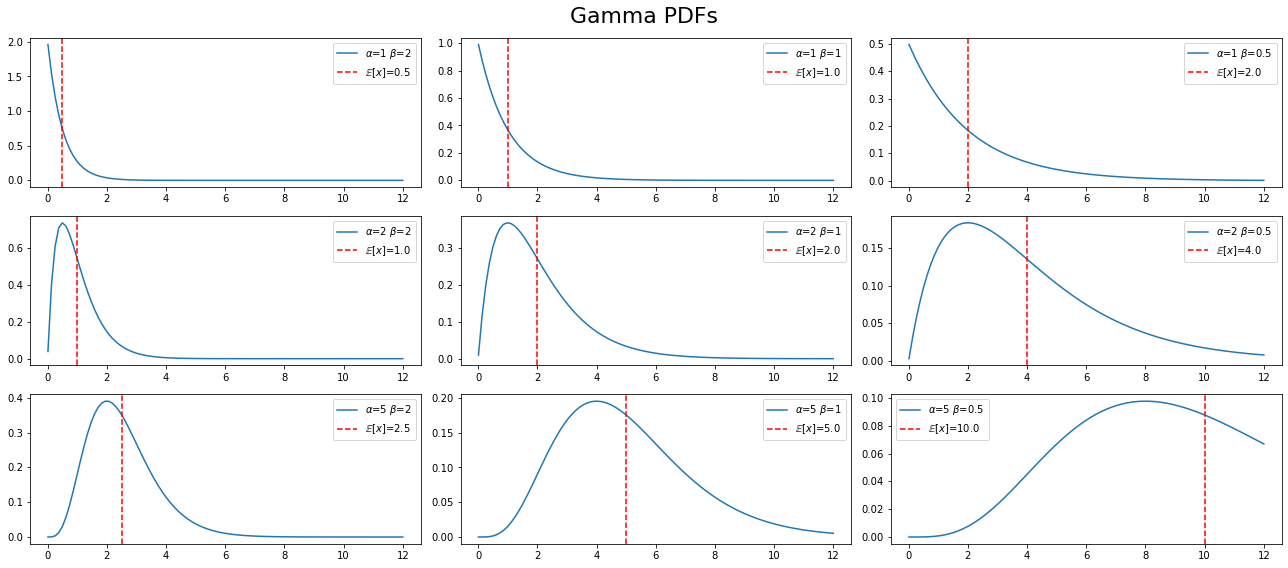

In [17]:
plot_gamma_pdfs(x_range, alphas, betas, log_gamma)

## $$\tb{Fitting a Gamma distribution}$$
<hr>
<br>

In [18]:
from scipy.stats import gamma

alpha, loc, beta = gamma.fit(feature_values)
alpha, loc, beta

(2.3347723203874535, 13.544209135338647, 7.692222988278269)

* $\t{Gamma PDF plot for the fitted values}$

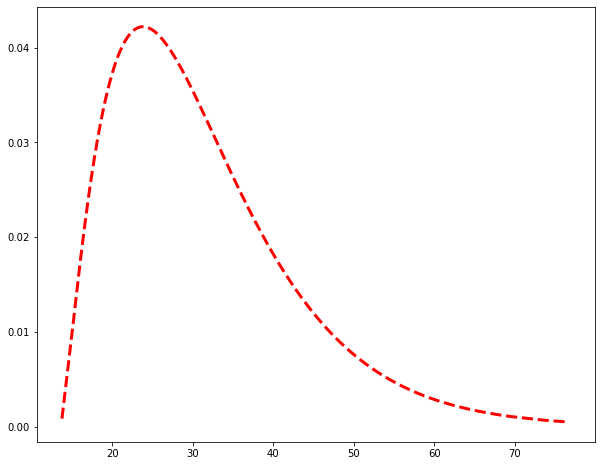

In [19]:
log_pdfs = gamma.logpdf(feature_values, a=alpha, loc=loc, scale=beta)
srt_idx = np.argsort(feature_values)

ax = plt.figure(figsize=(10, 8)).gca()
ax.plot(feature_values[srt_idx], np.exp(log_pdfs[srt_idx]), 'r--', linewidth=3);

## $$\tb{Histogram with a fitted Gamma distribution}$$
<hr>
<br>

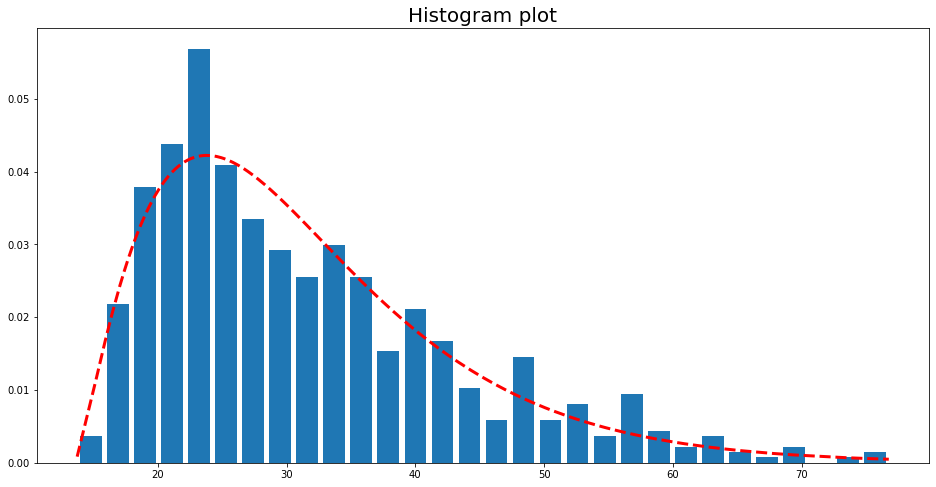

In [20]:
from scipy.stats import gamma

plot_hist(feature_values, likelihood=gamma);

## $$\textbf{Basics of probability theory}$$
<hr>
<br>


* $\t{Probability is something which quantifies uncertainty regarding the occurrence of an event.}$
<br><br><br>

<center>
<img src='./images/dice.png' width=350>

## $$\textbf{Probability space}$$
<hr>
<br>



$\text{Consist of the sample space } {\large{\Omega}} \text{, which is a set of all possible outcomes and}$
$\text{the probability measure } {\large P} \text{, which is a real function of the subsets of } \Omega.$
<br>
<br>
<center>
<img src='./images/Pr.png' width=450>
</center>
<br>

- $\text{A subset of outcomes } {\large{A \subseteq \Omega}} \text{ is called an event.}$
<br><br>
- $ {P(A)} \text{ represents how likely it is that the experiment’s actual outcome}$ <br> $\text{ will be a member of } {A.}$


$$P(A) = \frac{|A|}{|\Omega|}$$

## $$\textbf{Axioms of probability theory}$$
<hr>
<br>


* $P(A) \geq 0, \quad  \forall \text{ events } A$
<br><br>
* $P(\Omega) = 1$
<br><br>
* $P( A \cup B) = P(A) + P(B) \text{ for disjoint events } A \text{ and } B$
<br>
<br>

<center>
<img src='./images/Join.png' width=500>
</center>
<br>

## $$\textbf{Conjunction and disjunction of events}$$
<hr>
<br>


* $\textit{Product rule}: \text{conjunction of two events } A \text{ and } B$

$$P(A \cap B ) = P(A,B) = \underbrace{P(A \md B)}_{\tiny{\text{conditional probability}}}\cdot P(B) = P(B \md A)\cdot P(A)$$


* $\textit{Sum rule}: \text{disjunction of two events } A \text{ and } B$

$$P(A \cup B ) = P(A) + P(B) - P(A \cap B)$$


## $$\textbf{Marginalization (third rule)}$$
<hr>



* $\text{Discrete case:}$ 

$\text{     If events } B_1, \dots B_N \text{ are mutually exclusive with } \sum_{i=1}^N P(B_i) = 1, \text{  then}$

$$P(A) = \sum_{i=1}^N P(A,B_i) = \sum_{i=1}^N
P(A|B_i)P(B_i)$$

* $\text{Continous case: } {\Large{\int}}_{\Omega} P(B)\> dB = 1$

$$P(A) = {{\int}}_{\Omega} P(A,B)\> dB = {{\int}}_{\Omega}
P(A|B)P(B)$$

## $$\textbf{Bayes theorem}$$
<hr>

* $\text{Following the product rule  of probabilities:}$

$$ P(B \md A) \cdot P(A) = P(A \md B)\cdot P(B)\quad \Rightarrow $$

* $\text{Bayes theorem}$

$$\boxed{P(B \md A) = \frac{P(A \md B) \cdot P(B)}{P(A)}}$$

<br>
<br>
<center>
<img src='./images/thomas.png' width=350>

## $$\textbf{Bayes theorem extended form}$$
<hr>


* $\text{Appying continous marginalization and product rule in the denominator:}$

$${P(B \md A) = \frac{P(A \md B)\cdot P(B)}{{\Large{\int}}_{\Omega} P(A,B)\> dB}} \Rightarrow$$

* $\text{Extended Bayes theorem}$

$$\boxed{P(B \md A) = \frac{P(A \md B) \cdot P(B)}{{\Large{\int}}_{\Omega} P(A \md B) \cdot P(B)\> dB}}$$


## $$\textbf{Bayes theorem (cont'd)}$$
<hr>

* $\text{Bayes’ Theorem is a simple mathematical formula},$ $\text{that describes how to update the probabilities of hypotheses when evidence is given.}$

* $\text{Given a hypothesis } H \text{ and evidence } E.$

$${\Large{\underbrace{P(H \md E)}_{\text{posterior}} = \frac{\overbrace{P(E \md H)}^{\text{likelihood}} \cdot \overbrace{P(H)}^{\text{prior}}}{\underbrace{P(E)}_{\text{evidence}}}}}$$

$\text{In other words}$:

$$\boxed{{\t{posterior} \propto \t{likelihood } \times \t{ prior}}}$$

## $$\textbf{Bayesian learning}$$
<hr>

* $\text{Given datapoints } \mX \text{ and the data generation process via likelihood and prior distributions.}$



* $\text{The (posterior) distribution on the model parameters } w \t{ could be then expressed as:}$

$${\Large{\underbrace{P(w \md \D)}_{\color{red}{\text{posterior}}} = \frac{\overbrace{P(\D \md w)}^{\text{likelihood}} \cdot \overbrace{P(w)}^{\text{prior}}}{\underbrace{P(\D)}_{\text{marginal}}}}}$$

## $$\textbf{Bayes posterior distribution}$$
<hr>
<br>

$${\Large{\underbrace{\overbrace{p(w \md \mX )}^{\color{red}{\text{posterior}}} \cdot \overbrace{p(\mX)}^{\color{magenta}{\text{marginal}}}}_{\color{red}{\text{must compute}}} = \underbrace{\overbrace{p(w,\mX)}^{\text{joint}} =  \overbrace{p(\mX \md w)}^{\color{blue}{\text{likelihood}}} \cdot \overbrace{p(w)}^{\color{blue}{\text{prior}} }}_{\color{green}{\text{given}}}}}$$

## $$\textbf{Markov chain Monte Carlo (MCMC) methods}$$
<hr>
<br>

* $\text{Sampling methods able to drawn posterior samples from unnormalized distributions}$

$$\lrg{
w^{(j)} \sim \underbrace{p(w | \D)}_{\color{blue}{\text{unknown}}} \propto \underbrace{p(\D, w)}_{\color{green}\text{known}} = \underbrace{\overbrace{p(\D | w)}^{\text{likelihood}}\cdot \overbrace{p(w)}^{\text{prior}}}_{\text{not normalized}}
}$$

## $$\tb{Metropolis-Hastings (MH) method}$$
<hr>
<br>

* $\t{Random walk over an unnormalized probability space.}$
<br>
<br>

<center>
<img src='./images/mcmc.png' width=800>

## $$\tb{Metropolis-Hastings (cont'd)}$$
<hr>
<br>

$\text{In the $j$-th iteration,}$

$\quad \quad 1)\ \text{Draw a random walk sample}\ \lrg{
\ws \sim r(\ws | \wo ) \overbrace{=}^{\text{e.g.}}\ \mathcal{N}(\ws | \wo, \ \gamma)}$

$\quad \quad $2) $\t{Set the } j \t{-th sample to}$ 

$${
\wj = \begin{cases}
    \ws & \text{with probability}\ T,\\
    \wo & \text{with probability}\ 1-T,
  \end{cases}
}$$
<br>
$\quad\quad \text{ where the acceptance probability}\ T\ \text{satisfies the}\ \color{green}{\textbf{detailed balance property}}.$

## $$\tb{Detailed balance property}$$
<hr>



* $\t{Accept the sample (}\textit{ e.g. random.choice ([Accept, Decline])} \t{ ) with the given probability:}$
<br>
<br>

$$\lrg{
T = \min\bigg(\ 1 \ ,\ \frac{p(\ws,\ \D\ )\cdot r(\wo | \ws )}{p (\wo, \D\ ) \cdot r(\ws | \wo)}\ \bigg)
}$$

## $$\tb{Toy data generation process}$$
<hr>
<br>

* $\t{Prior distribution is defined over the model distribution parameters.}$

In [21]:
from scipy.stats import expon, gamma
seed = 42
np.random.seed(seed)

# Prior distribution is Gamma with alpha 3 and beta 0.1
rate = gamma.rvs(a=3, scale=0.1) 
rate

0.3562818662554703

* $\t{Model (likelihood) distribution generates the data for the given parameters.}$

In [22]:
# Model distribution is Exponential with lambda rate
D = expon.rvs(loc=0, scale=1/rate, size=100, random_state=seed) 

## $$\tb{Toy data  histogram plot}$$
<hr>
<br>

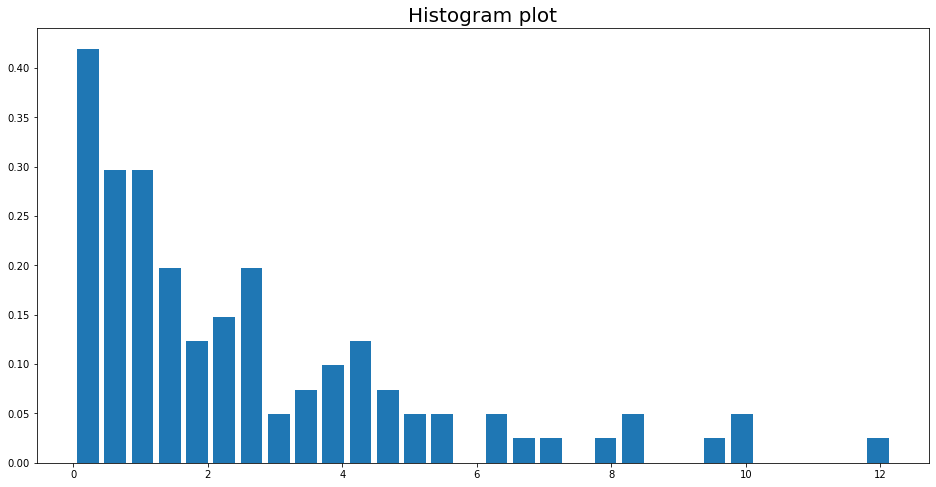

In [23]:
%matplotlib inline

plot_hist(D);

## $$\tb{Run Metropolis-Hastings algorithm}$$
<hr>

In [24]:
def metropolis_hastings(data, likelihood, prior, steps=1000, sigma=0.1):
    
    from scipy.stats import norm, bernoulli
    from tqdm import tqdm
    
    assert callable(likelihood), "The likelihood isn't a function"
    assert callable(prior), "The prior isn't a function"
    
    # Initial value to start a random walk
    w = 0.1
    sampled_w = np.array([])
    
    for i in tqdm(np.arange(steps)):
        
        # sample a new candidate entry ( random Gaussian walk ) 
        w_star = np.abs(norm.rvs(loc=w, scale=sigma))
        
        # ln(p(w*,D))
        ln_p_ws_D = likelihood.logpdf(D, scale=1/w_star).sum() 
        ln_p_ws_D += prior.logpdf(w_star, a=alpha, scale=1/beta)    
        
        # ln(p(w_{j-1}, D))
        ln_p_w_prev_D = likelihood.logpdf(D, scale=1/w).sum()
        ln_p_w_prev_D += prior.logpdf(w, a=alpha, scale=1/beta) 
        
        # log of the detailed balance property is computed
        T = np.exp(np.min([0, ln_p_ws_D - ln_p_w_prev_D]))
        
        accept = bernoulli.rvs(p = T) # draw the acceptance probability
        
        if accept:
            w = w_star
            sampled_w = np.append(sampled_w, w)
            
    return sampled_w

## $$\tb{Run Metropolis-Hastings (MH) sampler}$$
<hr>

In [26]:
# initial values for the prior hyperparameters
alpha, beta = [1, 0.5]

w_samples = metropolis_hastings(D, expon, gamma, steps=5_000)

100%|█████████████████████████████████████| 5000/5000 [00:03<00:00, 1617.86it/s]


In [27]:
w_samples.shape

(2140,)

* $\t{Drop some initial samples representing a burn-in period }$

In [28]:
burn_in_rate = 0.1
burn_in = int(burn_in_rate * len(w_samples))

ws = w_samples[burn_in:]
ws.shape

(1926,)

## $$\tb{MH samples trace plot}$$
<hr>

In [29]:
def trace_plot(x):
    
    ax = plt.figure(figsize=(12, 2)).gca()
    ax.set_title("Trace plot of the samples", fontsize=20)
    n_samples = len(x)
    
    ax.plot(np.arange(n_samples), x, c='y', alpha=0.5)
    
    mu = np.mean(x)
    ax.plot(np.arange(n_samples), mu * np.ones(n_samples), '--', c='k', label=f'sample mean = {mu:0.3f}')
    ax.set_yticks([])
    ax.legend()
    return ax 

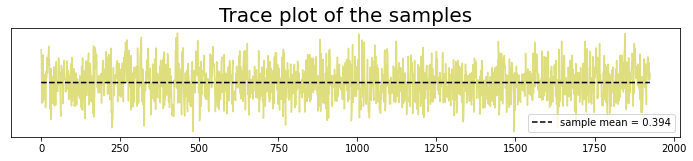

In [31]:
trace_plot(ws);

## $$\tb{Predictive density approximation}$$
<hr>

* $\t{Predictive density is defined for a new (unseen) data-point}$


$$\lrg{
p(x^* | \D, \alpha) = \int p(x^*,w | \D, \alpha)\ dw = \int p(x^* |\ w)\cdot p(w | \D, \alpha)\ dw
}$$

* $\t{Approximation}$

$$\boxed{\lrg{
p(x^* | \D, \alpha) \approx \frac1 J \sumJ p(x^* | \wj ), \where \wj \sim q(w).
}}$$

In [32]:
x_range = np.linspace(0.1, 15, 100)

approx_pred = expon.pdf(x_range[:, None], scale=1./ws[None]).mean(1)

## $$\tb{Predictive density plot}$$
<hr>

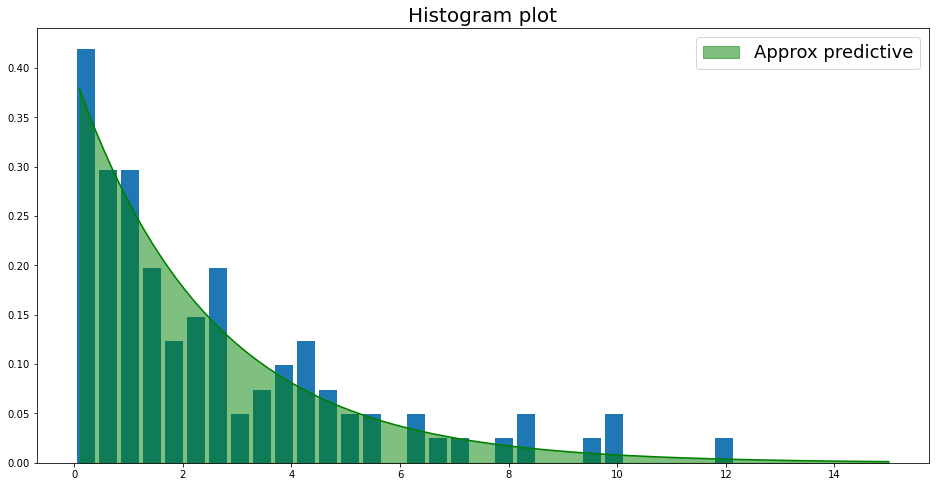

In [33]:
ax = plot_hist(D)

ax.plot(x_range, approx_pred, c='g')
ax.fill_between(x_range, 0, approx_pred, alpha=0.5, color='g', label='Approx predictive')
ax.legend(fontsize=18);

## $$\tb{Probabilistic programming language in Python}$$
<hr>
<br>

<center>
<img src='./images/pymc3.png' width=550>

* $\t{PyMC3 allows you to write down models using an intuitive syntax to describe a data generating process.}$

In [34]:
#conda install -c conda-forge pymc3
import numpy as np
import pymc3 as pm

import warnings
warnings.filterwarnings('ignore')

pm.__version__

'3.11.2'

## $$\tb{Generate artificial regression data}$$
<hr>
<br>

In [35]:
from scipy.stats import multivariate_normal

# Prior distribution over the model parameters
w = multivariate_normal(mean= 2*np.ones(2), cov=np.eye(2)).rvs()

n_datapoints = 100
sigma = 0.5 # noise value

# Gaussian noise
epsilon_noise = np.random.normal(0, sigma, size=n_datapoints)

x_range = np.linspace(0, 2, n_datapoints)
X = np.c_[x_range, np.ones(n_datapoints)]

y_truth = X @ w

y = y_truth + epsilon_noise 

## $$\tb{Generated data plots}$$
<hr>
<br>

In [58]:
def plot_data(x_range, y, y_hat):
    ax = plt.figure(figsize=(12, 8)).gca()

    ax.scatter(x_range, y, label='data samples')
    ax.plot(x_range, y_hat, '--', c='r', label='Groun truth')
    ax.legend(fontsize=18)
    
    return ax


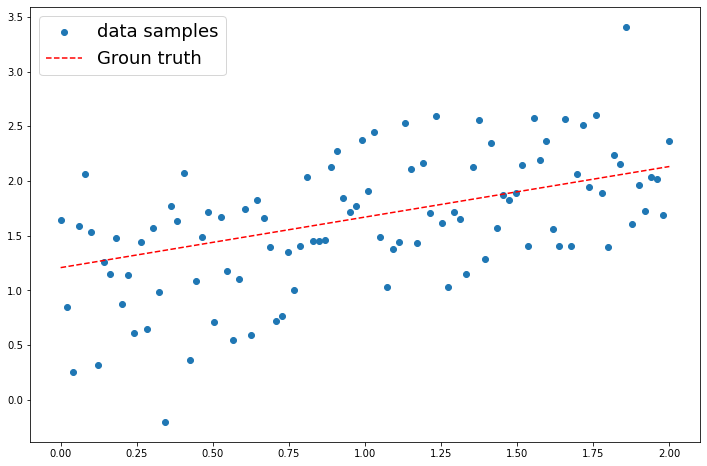

In [59]:
plot_data(x_range, y, y_truth);

## $$\tb{Zero-mean the data}$$
<hr>
<br>

In [60]:
# zero mean the data (works better for regression tasks) 
X_c = X - X.mean(axis=0)
assert np.allclose(X_c.mean(0), np.zeros(X.shape[1]))

## $$\tb{Define a generative process model}$$
<hr>
<br>

In [61]:
import pymc3 as pm

lin_reg = pm.Model()

x_c = X_c[:, 0]
with lin_reg:
    
    w_0 = pm.Normal('w_0', 0, 10) 
    w_1 = pm.Normal('w_1', 0, 1)
    
    sigma = pm.Gamma('sigma', alpha=1, beta=0.5) # fixed noise hyperparameters
    
    y_hat = pm.Normal('y', mu=w_0 + w_1 * x_c, sd=sigma, observed=y) # <- likelihood function
    

## $$\tb{Sampling over the probabilistic model}$$
<hr>
<br>

In [62]:
with lin_reg:
    
    m_step = pm.Metropolis() # Define sampler
    
    # Sampling start point as MAP estimator (not very efficient, high complexity, time consuming)
    map_start = pm.find_MAP() 
    
    trace = pm.sample(draws=10_000, step=m_step, start=map_start, tune=100, chains=2)

Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [w_1]
>Metropolis: [w_0]


Sampling 2 chains for 100 tune and 10_000 draw iterations (200 + 20_000 draws total) took 4 seconds.
The number of effective samples is smaller than 10% for some parameters.


## $$\tb{Summary over the sampled values}$$
<hr>
<br>

In [63]:
with lin_reg:
    summary_df = pm.stats.summary(trace)

summary_df

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
w_0    1.613  0.050   1.510    1.697      0.002    0.001     895.0     812.0   
w_1    0.596  0.091   0.433    0.773      0.002    0.002    1576.0    1407.0   
sigma  0.510  0.037   0.444    0.578      0.001    0.001    1029.0     947.0   

       r_hat  
w_0      1.0  
w_1      1.0  
sigma    1.0

## $$\tb{Trace plot for the variables}$$
<hr>
<br>

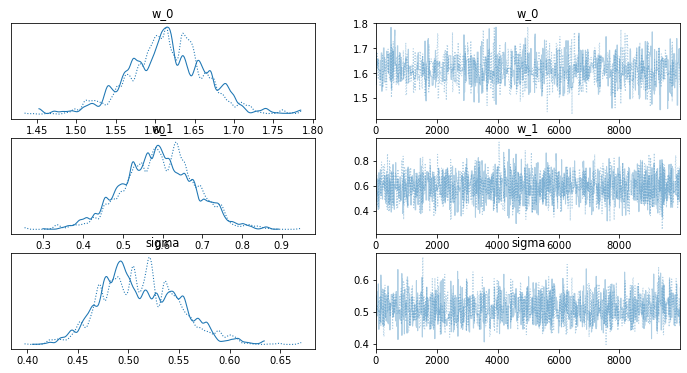

In [50]:
with lin_reg:
    sampling_plots = pm.traceplot(trace)
    
sampling_plots;

## $$\tb{Probabilistic model prediction}$$
<hr>
<br>

In [64]:
w_0_hat, w_1_hat, sigma = tuple(summary_df['mean'].values)

# Prediction using the expected values
y_hat = w_0_hat + w_1_hat * x_c
y_hat[:10]

array([1.017     , 1.0290404 , 1.04108081, 1.05312121, 1.06516162,
       1.07720202, 1.08924242, 1.10128283, 1.11332323, 1.12536364])

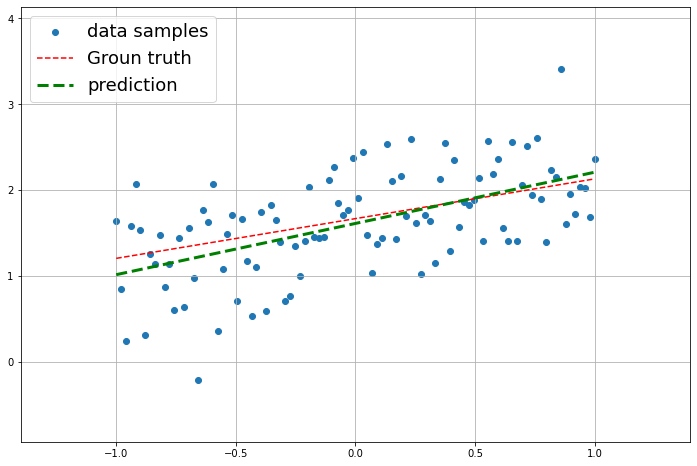

In [68]:
ax = plot_data(x_c, y, y_truth)
ax.plot(x_c, y_hat,'g--', label='prediction', linewidth=3)
ax.grid()
ax.margins(0.2)
ax.legend(fontsize=18);

## $$\tb{Posterior predictive samples}$$
<hr>
<br>

In [69]:
with lin_reg:
    
    ppc = pm.sample_posterior_predictive(trace, samples=1000)

In [70]:
 ppc.keys(), ppc['y'].shape

(dict_keys(['y']), (1000, 100))

In [71]:
y_pp = ppc['y']

y_pp_mean = y_pp.mean(0)
y_pp_std = y_pp.std(0) 
y_pp_var = y_pp.var(0) # std ** 2 

y_pp_mean.shape, y_pp_std.shape

((100,), (100,))

## $$\tb{Posterior density region plot}$$
<hr>
<br>

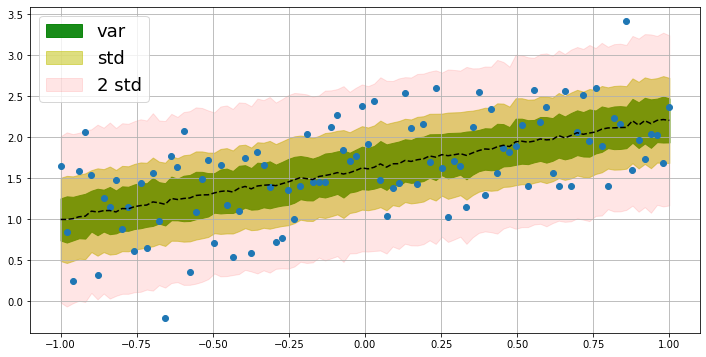

In [72]:
ax = plt.figure(figsize=(12, 6)).gca()
ax.plot(x_c, y, 'o')
ax.plot(x_c, y_pp_mean, 'k--')

ax.fill_between(x_c, y_pp_mean - y_pp_var, y_pp_mean + y_pp_var, color='g', alpha=0.9, label='var')
ax.fill_between(x_c, y_pp_mean - y_pp_std, y_pp_mean + y_pp_std, color='y', alpha=0.5, label='std' )
ax.fill_between(x_c, y_pp_mean - 2*y_pp_std, y_pp_mean + 2*y_pp_std, color='r', alpha=0.1, label='2 std' )

ax.legend(fontsize=18)
ax.grid();

# $$ \textbf{Thank you for your attention.}$$